**Problem**: 

I want to approximate the non-linear data space that makes up a PyPSA simulation. Specifically, I want to approximate a modified IEEE 13 bus topology with a uniform (grid) input. Keeping model training time low is important.

**Objective**:

This notebook will only look at [deep neural networks](https://stats.stackexchange.com/questions/182734/what-is-the-difference-between-a-neural-network-and-a-deep-neural-network-and-w) (DNN). Per [1], the approximation should have a root mean sqaure error < 0.002 to ensure the approximation is not the largest source of error in the simulation. A standard linear regression will be used as a baseline. Since the approximation is time sensitive, a search for the ball park number of samples required for reasonable scores is performed. Once the number of samples to produce reasonable results is found, a grid search can be ran to determine optimal training parameters.

**Hypothesis**: 

Previously, linear regression models outperformed artificial neural networks when tested on simple, small radial networks [2]. Since the modified IEEE 13 bus network contains two transformers whos behaviour can become non-linear if their power limit is exceeded (which is allowed in power flow [3]), I suspect there are two possible scenarios:

1. Limit not exceeded: Linear regression outperforms DNN
2. Limit exceeded: DNN outperforms linear regressor because a DNN can capture non-linearity 

As for the number of samples required, historically 1e5-1e6 samples produces K-fold cross validation scores with low variance if the feature-label correlation is reasonable.

**Experimental Procedure**:

1. Determine the number of samples required to return reasonable scores with a three hidden layer, one hundred neurons per hidden layer, DNN K-fold cross validation. Reasonable scores is defined as:
  * R2 > 0.8
  * RMSE < 0.002
  * K-fold R2 variance one degree of magnitude less than R2
2. Using approximately that number of samples, run grid search to determine optimal parameters/hyperparameters

**Results**:

* 1e5 samples (mean R2: 0.84, std dev: 0.073)
* 1e4 samples (mean R2: 0.77, std dev: 0.081)

1e5 samples produced the best, most consistent results; roughly a 9% improvement over the next best, 1e4 samples, with a smaller standard deviation.



**Discussion**:

One approach to reduce the cost of simulation-based research is to copy the underlying model and evaluate the approximation [1][4].

It takes roughly 7 hours to create 1e5 samples (by running PyPSA sim) on Intel(R) Xeon(R) CPU E5-2650 v4 @ 2.20GHz


**Bibliography**

[1] https://github.com/mbardwell/masters

[2] Enhancing Power Flow Simulations Using Function Mapping. Michael Bardwell ; Petr Musilek. 2019 IEEE Canadian Conference on Electrical and Computer Engineering (CCECE)

[3] https://groups.google.com/forum/#!searchin/pypsa/mikey%7Csort:date/pypsa/FqfC_UR85k0/vBc7HYP_EQAJ

[4] ieee-13_timing-pfsim-vs-evaluating-models.ipynb


Table of Contents:
* Source data
* Analyse data
* Setup models
* Determine number of samples to get reasonable scores
* Search

In [1]:
import copy
import csv
import importlib
import logging
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pypsa
import seaborn as sns

warnings.filterwarnings('ignore')
logger = logging.getLogger("pypsa")
logger.setLevel("WARNING")
%matplotlib inline

In [2]:
def personalise_column_names(df, name):
        new_columns = []
        for column in df.columns:
            new_columns.append(name + "-" + str(column))
        df.columns = new_columns
        return pd.DataFrame(df)


def collect_data(path_to_powerflow_data, data):
    '''
    Assumes folder tree has
    path_to_powerflow_data/
    -->datafiles
    -->results/
    '''
    import pandas as pd
    
    data["loads"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "loads-p_set.csv"), "load")
    data["vmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vmags.csv"), "vmag")
    data["vangs"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vangs.csv"), "vang")
    data["qmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "qmags.csv"), "qmag")
    data["linemags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "linemags.csv"), "linemag")


def set_uniform_sample_size(path_to_powerflow_data, data_to_change, n_samples, seed=None):
    '''

    Parameters
    ----------
    data_to_change: list of strings.
        ex: ["loads-p_set", "generators-p_max_pu", "snapshots"] 
    '''

    data = {}
    for datatype in data_to_change:
        data[datatype] = pd.read_csv(path_to_powerflow_data + datatype + ".csv")

    def increase_data(dataframe, n_samples, seed=None):
        addon = {}
        new_df_list = []
        for idx, column in enumerate(dataframe):
          
            if dataframe[column].dtype == np.float64 or dataframe[column].dtype == np.int64:
                ## special cases
                if datatype == "generators-p_max_pu":
                    # add a ridiculous amount of generation so the is always enough power and sim doesn't fail
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=100, high=200, size=n_samples)
                elif datatype == "snapshots":
                    addon[column] = np.ones(n_samples)
                else:
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=0, high=0.5, size=n_samples)
            elif dataframe[column].dtype == object:
                # assuming object is datetime column
                latest_datetime = pd.to_datetime(dataframe[column][0])
                addon[column] = []
                for sample in range(n_samples):
                    addon[column].append(latest_datetime + pd.Timedelta(hours=(1+sample)))
            else:
                raise TypeError("dataframe[column] type: {} should be object or float64/int64".format(
                    type(dataframe[column].dtype)))
        addon_dataframe = pd.DataFrame(addon)
        return dataframe.head(1).append(addon_dataframe)

    for datatype in data:
        data[datatype] = increase_data(data[datatype], n_samples-1, seed) # -1 is for original sample, which stays
        data[datatype].to_csv(path_to_powerflow_data + datatype + ".csv", index=False)
        print("Datatype {} stored".format(datatype))


def create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None):
    import os
    from pathlib import Path
    import shutil
    
    import pypsa

    if not os.path.isdir(path_to_powerflow_data):
        src = Path(path_to_powerflow_data).parents[0] / "ieee-13-with-load-gen/"  # original modified IEEE model
        shutil.copytree(src, path_to_powerflow_data)

    set_gaussian_sample_size(path_to_powerflow_data, data_to_change, sample_size, seed=None)

    network = pypsa.Network(import_name=path_to_powerflow_data)
    network.pf()

    save_path = path_to_powerflow_data + "results/"
    network.buses_t.v_mag_pu.to_csv(save_path + "vmags.csv")
    network.buses_t.v_ang.to_csv(save_path + "vangs.csv")
    network.buses_t.q.to_csv(save_path + "qmags.csv")
    network.lines_t.p0.to_csv(save_path + "linemags.csv")


def backup_samples(src, dest):
    '''
    thanks https://www.pythoncentral.io/how-to-recursively-copy-a-directory-folder-in-python/
    '''
    import errno
    import os
    import shutil

    try:
        if os.path.isdir(dest):
            shutil.rmtree(dest)
        shutil.copytree(src, dest)
        print("Backup to {} successful".format(dest))
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Backup was not successful. Directory not copied. Error: %s' % e)



def add_mean_and_std_rows(dataframe):
    mean = dataframe.mean()
    std = dataframe.std()
    dataframe.loc["mean"] = mean
    dataframe.loc["std"] = std
    return dataframe


def maxae(y, y_pred, **kwargs):
    import numpy as np
    return max(np.abs(y-y_pred).ravel())

def rmse(y, y_pred, **kwargs):
    import operator
    return np.sqrt(np.mean(np.square(list(map(operator.sub, y, y_pred)))))

def set_data_size(features, labels, n_samples, n_training_samples):
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val, train_idx, test_idx = train_test_split(features,
                                                                           labels,
                                                                           range(features.shape[0]),
                                                                           train_size=n_training_samples,
                                                                           test_size=n_samples-n_training_samples,
                                                                           random_state=None)

    X_train = X_train.values
    y_train = y_train.values
    X_val = X_val.values
    y_val = y_val.values

    return X_train, y_train, X_val, y_val, test_idx, train_idx

def train_models_on_given_sample_size(regression_model, features, labels, n_samples_array=[100, 1000, 10000, 100000], prompt=True):
    """
    Trains regression model on a variety of sample sizes
    
    parameters
    ----------
    features: pandas DataFrame
    labels: pandas DataFrame
    n_sample_array: array
        ex: [100, 1000, 10000, 100000]
    regression_model: sklearn regressor
        ex: RandomForestRegressor
    """
    import datetime

    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import make_scorer, r2_score
    from sklearn.metrics import mean_absolute_error as mae
    from sklearn.model_selection import cross_validate, train_test_split
    from tabulate import tabulate
    
    if prompt == True:
        savefile_descriptor_addon = input("Add on extra descriptor to saved file (ex: -testing_maxae)? ")
    else:
        if isinstance(prompt, str):
            savefile_descriptor_addon = prompt
        else:
            print("Prompt not a string. Foregoing descriptor")
            savefile_descriptor_addon = ''
    linear = LinearRegression()
    common_cross_validate_variables = {"cv": 5,
                                       "n_jobs": -1,
                                       "scoring": {"r2": make_scorer(r2_score), 
                                                   "rmse": make_scorer(rmse),
                                                   "mae": make_scorer(mae),
                                                   "maxae": make_scorer(maxae)}}
    summary = {}

    for i, n_samples in enumerate(n_samples_array):
        current_iteration = i

        # do not split data into train/val; cross_validate will automatically do that
        samples_to_use = np.random.randint(0, features.shape[0], n_samples)
        X = features.iloc[samples_to_use].values
        y = labels.iloc[samples_to_use].values
        
        print("\n\nRun: ", current_iteration)
        print("n_samples for k fold cross validation: ", n_samples)
        print("n_features: ", X.shape[1])
        print("n_labels: ", y.shape[1])

        ## regression model to evaluate
        print("\n\n{} REGRESSION\n\n".format(regression_model_name.upper()))
        time_start = time.time()
        regression_model_results = pd.DataFrame(cross_validate(regression_model, X, y, 
                                                               **common_cross_validate_variables))
        time_regression_model = time.time()
        print("cross validation training time {:.5}".format(time_regression_model-time_start))
        print("cross validation training scores: ")
        regression_model_results.columns = [regression_model_name+"_"+col for col in regression_model_results.columns]
        regression_model_results = add_mean_and_std_rows(regression_model_results)
        display(regression_model_results)

        print("non-cross validation model scores for reference:")
        n_training_samples = int(n_samples*80/100)
        X_train, y_train, X_val, y_val, _, _ = set_data_size(features, labels, n_samples, n_training_samples)
        regression_model.fit(X_train, y_train)
        print("n_training_samples: ", n_training_samples)
        print("n_validation_samples: ", n_samples-n_training_samples)
        print("training score: ", r2_score(y_train, regression_model.predict(X_train)))
        print("validation score: ", r2_score(y_val, regression_model.predict(X_val)))
        print("rmse: ", rmse(regression_model.predict(X_val), y_val))



        ## linear regression for baseline comparison
        print("\n\nLINEAR REGRESSION\n\n")
        time_start = time.time()
        linear_results = pd.DataFrame(cross_validate(linear, X, y, **common_cross_validate_variables))
        time_linear = time.time()
        print("cross validation training time {:.5}".format(time_linear-time_start))
        print("cross validation training scores: ")
        linear_results.columns = ["linear_"+col for col in linear_results.columns]
        linear_results = add_mean_and_std_rows(linear_results)
        display(linear_results)

        linear.fit(X_train, y_train)
        print("non-cross validation model scores for reference:")
        print("training score: ", r2_score(y_train, linear.predict(X_train)))
        print("validation score: ", r2_score(y_val, linear.predict(X_val)))
        print("rmse: ", rmse(linear.predict(X_val), y_val))



        ## save models
        datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
        results_to_save = regression_model_results.join(linear_results)
        results_to_save.to_csv(path_to_powerflow_data + 
                               "/results/approximating_with_{}_model_results-{}_samples-uniform_input-{}{}.csv".format(
                                   regression_model_name,
                                   n_samples, 
                                   datetimestamp,
                                   savefile_descriptor_addon))
        
        summary[n_samples] = results_to_save.loc["mean"].values

    summary = pd.DataFrame(summary, index=results_to_save.columns)
    summary_table = tabulate(summary, tablefmt="pipe", headers="keys")
    print("\n\nSUMMARY\n\n", summary_table)
    with open(path_to_powerflow_data + "/results/approximating_with_{}_model_summary-uniform_input-{}{}.txt".format(
                  regression_model_name,
                  datetimestamp,
                  savefile_descriptor_addon), "w") as f:
        f.write(summary_table)

# Source Data

In [3]:
## USER INPUT
sample_size = 100000 # this is the max number of samples available

data_to_change = ["loads-p_set", "snapshots", "loads-q_set"]

path_to_powerflow_example = "../../pypsa/examples/ieee-13/"
path_to_powerflow_data = (path_to_powerflow_example + "/ieee-13-with-load-gen-uniform-data-" +
                          str(sample_size) + "-samples/")
path_to_powerflow_results = path_to_powerflow_data + "results/"

In [4]:
## Uncomment to generate load samples for modified IEEE-13 network
# if sample_size > 10000:
#     user = input("Are you sure [y/n]? This could erase hours worth of data")
#     if user == "y":
#         backup_samples(path_to_powerflow_results, path_to_powerflow_data + "results-backup/")
#         create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)
# else:
#     create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)

data = {"loads": [], "vmags": [], "vangs": [], "qmags": [], "linemags": []}
collect_data(path_to_powerflow_data, data)

# Analyse Data

In [5]:
features = data["loads"].drop("load-name", axis=1)
labels = data["vmags"].drop(["vmag-name", "vmag-Substation"], axis=1)
features_and_labels = features.join(labels)

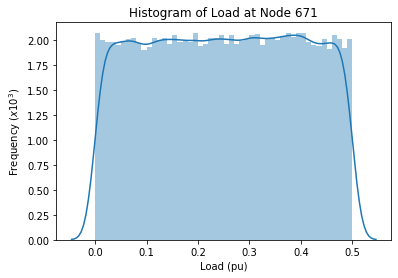

In [6]:
sns.distplot(features["load-671"], bins=50)
plt.xlabel("Load (pu)")
plt.ylabel("Frequency ($x10^3$)")
plt.title("Histogram of Load at Node 671")
# plt.savefig("uniform-samples-1e5-input-histogram.pdf")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe138373d10>,
      dtype=object)

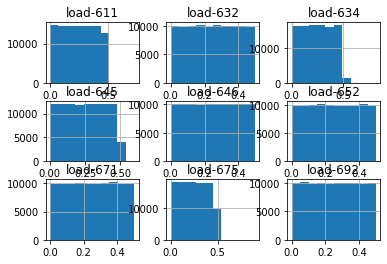

In [7]:
features.hist()

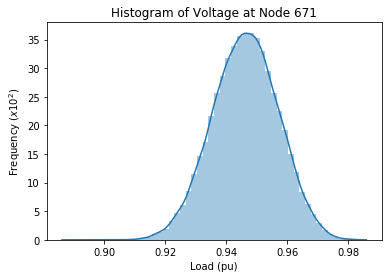

In [8]:
sns.distplot(labels["vmag-671"], bins=50)
plt.xlabel("Load (pu)")
plt.ylabel("Frequency ($x10^2$)")
plt.title("Histogram of Voltage at Node 671")
# plt.savefig("uniform-samples-1e5-voltage-histogram.pdf")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe13d109ed0>,
      dtype=object)

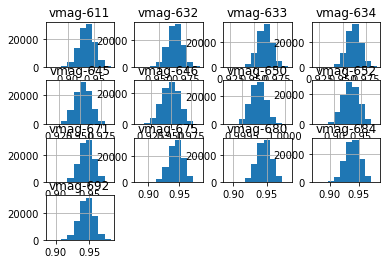

In [9]:
labels.hist()

In [10]:
corr_matrix = labels.join(features).corr()

# only loads for columns
cols = [c for i, c in enumerate(corr_matrix.columns) if corr_matrix.keys().str.contains("^load", regex=True)[i]]
reduced_corr_matrix = corr_matrix[cols]
reduced_corr_matrix["row average"] = pd.Series(reduced_corr_matrix.mean(axis=1))
# only voltages for rows
rows = reduced_corr_matrix.index[reduced_corr_matrix.index.str.contains("load")]
reduced_corr_matrix.drop(rows, inplace=True)
reduced_corr_matrix = reduced_corr_matrix.append(pd.Series(reduced_corr_matrix.mean(), name="column average"))

display(reduced_corr_matrix)

,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611,row average
vmag-650,-0.008439,0.001458,-0.002953,-0.000081,-0.001955,-0.007134,-0.001353,-0.004306,-0.001971,-0.002970
vmag-646,-0.196512,-0.200144,-0.487273,-0.671172,-0.211606,-0.204674,-0.199273,-0.208235,-0.211118,-0.287779
vmag-645,-0.219407,-0.223990,-0.546822,-0.558979,-0.235927,-0.229190,-0.223332,-0.233060,-0.236599,-0.300812
vmag-632,-0.316812,-0.320804,-0.319882,-0.333944,-0.339195,-0.329811,-0.324215,-0.334387,-0.339914,-0.328774
vmag-633,-0.286406,-0.512513,-0.289868,-0.302645,-0.307178,-0.298881,-0.292050,-0.303695,-0.307554,-0.322310
vmag-634,-0.286326,-0.512387,-0.289801,-0.302548,-0.307111,-0.298800,-0.291940,-0.303616,-0.307463,-0.322221
vmag-611,-0.157880,-0.158084,-0.155850,-0.168281,-0.463138,-0.316864,-0.313902,-0.320260,-0.600170,-0.294936
vmag-684,-0.170285,-0.171447,-0.168631,-0.182151,-0.502244,-0.343257,-0.340429,-0.346904,-0.501052,-0.302933
vmag-671,-0.196724,-0.199334,-0.196651,-0.210183,-0.410146,-0.399117,-0.395772,-0.403272,-0.410221,-0.313491
vmag-692,-0.196689,-0.199299,-0.196616,-0.210148,-0.410075,-0.399049,-0.395916,-0.403413,-0.410151,-0.313484


# Determine number of samples to get reasonable scores

In [15]:
# setup model parameters/hyperparameters

'''
dnn hyperparameters are chosen from sandbox testing. On average the model attempts to converge 
(with other parameters it sometimes gives up early).
'''
from sklearn.neural_network import MLPRegressor

hidden_layer_size = 10
regression_model = MLPRegressor(hidden_layer_sizes=(hidden_layer_size, hidden_layer_size),
                   activation="logistic",
                   solver="lbfgs",
                   alpha=0.000001,
                   learning_rate_init=1e-5,
                   max_iter=3000,
                   n_iter_no_change=100,
                   tol=1e-8,
                  )

regression_model_name = "dnn"

In [16]:
train_models_on_given_sample_size(regression_model, features, labels, n_samples_array=[100, 1000, 10000, 100000],
                                  prompt="-baseline")



Run:  0
n_samples for k fold cross validation:  100
n_features:  9
n_labels:  13


DNN REGRESSION


cross validation training time 0.15968
cross validation training scores: 


,dnn_fit_time,dnn_score_time,dnn_test_r2,dnn_test_rmse,dnn_test_mae,dnn_test_maxae
0,0.047936,0.002188,-30.950130,0.003027,0.002233,0.010856
1,0.039639,0.001887,-29.034733,0.003879,0.003061,0.010975
2,0.029564,0.001908,-9.750653,0.003864,0.002859,0.013754
3,0.028274,0.001893,-81.076346,0.003233,0.002427,0.009947
4,0.019688,0.001459,-34.208991,0.003100,0.002301,0.011649
mean,0.033020,0.001867,-37.004170,0.003421,0.002576,0.011436
std,0.010937,0.000261,26.424833,0.000418,0.000365,0.001431


non-cross validation model scores for reference:
n_training_samples:  80
n_validation_samples:  20
training score:  -14.553251313158027
validation score:  -26.514987449260477
rmse:  0.0034739338508813313


LINEAR REGRESSION


cross validation training time 0.028238
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.003172,0.001846,0.895623,0.001233,0.000944,0.003794
1,0.001051,0.001642,0.891981,0.001661,0.001197,0.005633
2,0.001877,0.001982,0.850061,0.001544,0.001145,0.005594
3,0.001156,0.001176,0.846969,0.001549,0.001236,0.004278
4,0.001589,0.001417,0.905718,0.001427,0.001115,0.004957
mean,0.001769,0.001613,0.878070,0.001483,0.001128,0.004851
std,0.000852,0.000324,0.027467,0.000162,0.000113,0.000809


non-cross validation model scores for reference:
training score:  0.9241156115346809
validation score:  0.8768853097130324
rmse:  0.0014059912629201105


Run:  1
n_samples for k fold cross validation:  1000
n_features:  9
n_labels:  13


DNN REGRESSION


cross validation training time 0.26423
cross validation training scores: 


,dnn_fit_time,dnn_score_time,dnn_test_r2,dnn_test_rmse,dnn_test_mae,dnn_test_maxae
0,0.132170,0.015034,-61.682338,0.003476,0.002596,0.014846
1,0.098001,0.002929,-195.840981,0.004807,0.003722,0.019795
2,0.107552,0.002890,-104.113029,0.004131,0.003054,0.019353
3,0.148067,0.003045,-347.919137,0.004484,0.003556,0.018146
4,0.136768,0.002832,-39.996084,0.003895,0.002910,0.031286
mean,0.124512,0.005346,-149.910314,0.004159,0.003167,0.020685
std,0.020942,0.005416,125.777408,0.000516,0.000465,0.006235


non-cross validation model scores for reference:
n_training_samples:  800
n_validation_samples:  200
training score:  -208.76650489165857
validation score:  -191.80373768725124
rmse:  0.004512423534748498


LINEAR REGRESSION


cross validation training time 0.02859
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.001713,0.002364,0.907673,0.001356,0.001021,0.005369
1,0.001592,0.002574,0.905560,0.001300,0.000993,0.005433
2,0.001792,0.002424,0.897380,0.001447,0.001099,0.005452
3,0.001678,0.002274,0.902367,0.001470,0.001123,0.006783
4,0.001196,0.002125,0.899943,0.001538,0.001139,0.008928
mean,0.001594,0.002352,0.902585,0.001422,0.001075,0.006393
std,0.000234,0.000168,0.004149,0.000094,0.000064,0.001536


non-cross validation model scores for reference:
training score:  0.9068068331554128
validation score:  0.9040891373061115
rmse:  0.001456933154486332


Run:  2
n_samples for k fold cross validation:  10000
n_features:  9
n_labels:  13


DNN REGRESSION


cross validation training time 1.6556
cross validation training scores: 


,dnn_fit_time,dnn_score_time,dnn_test_r2,dnn_test_rmse,dnn_test_mae,dnn_test_maxae
0,1.618148,0.016459,-5.660270,0.003112,0.002296,0.017107
1,1.021904,0.016725,-26.154144,0.003205,0.002366,0.018577
2,0.926600,0.032197,-47.683112,0.003315,0.002488,0.017524
3,0.702623,0.016973,-117.461781,0.003749,0.002855,0.023776
4,0.340182,0.014232,-75.869782,0.003613,0.002762,0.018156
mean,0.921891,0.019317,-54.565818,0.003399,0.002554,0.019028
std,0.469378,0.007282,43.749596,0.000272,0.000245,0.002714


non-cross validation model scores for reference:
n_training_samples:  8000
n_validation_samples:  2000
training score:  -11.962947573574262
validation score:  -12.141025776368734
rmse:  0.0034145798604494726


LINEAR REGRESSION


cross validation training time 0.11616
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.042158,0.011364,0.907991,0.001349,0.001026,0.007121
1,0.036378,0.021084,0.905996,0.001397,0.001055,0.009020
2,0.035313,0.020372,0.904897,0.001434,0.001091,0.006781
3,0.006684,0.009686,0.904942,0.001403,0.001076,0.006567
4,0.005940,0.019013,0.905263,0.001394,0.001057,0.005916
mean,0.025295,0.016304,0.905818,0.001396,0.001061,0.007081
std,0.017525,0.005361,0.001292,0.000030,0.000025,0.001170


non-cross validation model scores for reference:
training score:  0.905104732832722
validation score:  0.9056828761456445
rmse:  0.00139738024927209


Run:  3
n_samples for k fold cross validation:  100000
n_features:  9
n_labels:  13


DNN REGRESSION


cross validation training time 11.031
cross validation training scores: 


,dnn_fit_time,dnn_score_time,dnn_test_r2,dnn_test_rmse,dnn_test_mae,dnn_test_maxae
0,4.217668,0.247931,-68.032216,0.003546,0.002634,0.023689
1,6.031865,0.270058,-325.095252,0.004120,0.003228,0.029055
2,4.474130,0.246557,-217.960644,0.004156,0.003118,0.026907
3,9.983408,0.241836,-43.691256,0.003471,0.002565,0.020295
4,6.229602,0.238099,-222.797614,0.003937,0.003006,0.023313
mean,6.187335,0.248896,-175.515396,0.003846,0.002910,0.024652
std,2.304929,0.012456,117.623954,0.000320,0.000295,0.003398


non-cross validation model scores for reference:
n_training_samples:  80000
n_validation_samples:  20000
training score:  -17.01685042066184
validation score:  -17.374798667799766
rmse:  0.0035059485084928295


LINEAR REGRESSION


cross validation training time 0.65838
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.184784,0.194460,0.906098,0.001394,0.001060,0.007702
1,0.186848,0.193053,0.905775,0.001398,0.001064,0.008525
2,0.099114,0.192175,0.905904,0.001406,0.001071,0.007173
3,0.126136,0.195775,0.905841,0.001399,0.001066,0.007084
4,0.096892,0.169972,0.905329,0.001404,0.001065,0.007697
mean,0.138755,0.189087,0.905789,0.001400,0.001065,0.007636
std,0.044482,0.010773,0.000284,0.000005,0.000004,0.000574


non-cross validation model scores for reference:
training score:  0.905767594434168
validation score:  0.9059087940181233
rmse:  0.0013904748461531682


SUMMARY

 |                   |          100 |          1000 |        10000 |        100000 |
|:------------------|-------------:|--------------:|-------------:|--------------:|
| dnn_fit_time      |   0.0330201  |    0.124512   |   0.921891   |    6.18733    |
| dnn_score_time    |   0.00186691 |    0.00534616 |   0.0193171  |    0.248896   |
| dnn_test_r2       | -37.0042     | -149.91       | -54.5658     | -175.515      |
| dnn_test_rmse     |   0.00342083 |    0.00415857 |   0.00339861 |    0.0038462  |
| dnn_test_mae      |   0.00257619 |    0.00316731 |   0.00255361 |    0.00291014 |
| dnn_test_maxae    |   0.0114361  |    0.0206853  |   0.0190278  |    0.0246517  |
| linear_fit_time   |   0.00176916 |    0.00159426 |   0.0252947  |    0.138755   |
| linear_score_time |   0.00161276 |    0.002352   |   0.0163036  |    0.189087  

# Try different feature/label preprocessing techniques

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer

# test normalizing labels
estimators = [("normalise", Normalizer()),
              ('regression', regression_model)]
preprocessed_model = Pipeline(estimators)
train_models_on_given_sample_size(preprocessed_model, features, labels, n_samples_array=[100000],
                                  prompt="-normalise")



Run:  0
n_samples for k fold cross validation:  100000
n_features:  9
n_labels:  13


RF REGRESSION


cross validation training time 575.78
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,180.737735,6.321322,0.823514,0.003947,0.002444,0.039813
1,186.038787,7.111364,0.816794,0.004011,0.002461,0.045390
2,181.824398,6.305795,0.825510,0.003912,0.002422,0.048416
3,184.091817,6.106032,0.819126,0.003992,0.002440,0.073614
4,190.487922,5.695157,0.822650,0.003934,0.002426,0.051371
mean,184.636132,6.307934,0.821519,0.003959,0.002438,0.051721
std,3.860392,0.515253,0.003508,0.000041,0.000015,0.012964


non-cross validation model scores for reference:
n_training_samples:  80000
n_validation_samples:  20000
training score:  0.9508151059673364
validation score:  0.6485286243753635
rmse:  0.005553626462437978


LINEAR REGRESSION


cross validation training time 2.7463
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.250580,0.287666,0.905862,0.001398,0.001063,0.008961
1,0.142021,0.211166,0.905245,0.001418,0.001078,0.008964
2,0.168630,0.172260,0.905979,0.001393,0.001061,0.007757
3,0.115285,0.210562,0.905730,0.001399,0.001063,0.008486
4,0.110515,0.206882,0.905401,0.001410,0.001073,0.008968
mean,0.157406,0.217707,0.905643,0.001404,0.001068,0.008627
std,0.057046,0.042340,0.000310,0.000010,0.000008,0.000529


non-cross validation model scores for reference:
training score:  0.9057476562846737
validation score:  0.9059553552533443
rmse:  0.0013920146405381674


SUMMARY

 |                   |       100000 |
|:------------------|-------------:|
| rf_fit_time       | 184.636      |
| rf_score_time     |   6.30793    |
| rf_test_r2        |   0.821519   |
| rf_test_rmse      |   0.00395903 |
| rf_test_mae       |   0.00243844 |
| rf_test_maxae     |   0.051721   |
| linear_fit_time   |   0.157406   |
| linear_score_time |   0.217707   |
| linear_test_r2    |   0.905643   |
| linear_test_rmse  |   0.00140367 |
| linear_test_mae   |   0.00106755 |
| linear_test_maxae |   0.00862724 |


In [12]:
# test outlier removal
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.pipeline import Pipeline

def find_outliers(df, m=3):
    """
    Thanks https://stackoverflow.com/questions/21448225/getting-indices-of-true-values-in-a-boolean-list
    """
    from itertools import compress
    
    import numpy as np
    
    outliers = []
    for col in df:
        data = df[col]
        positions = abs(data - np.mean(data)) > m * np.std(df[col])
        outliers.append(list(compress(range(len(positions.values)), positions.values)))
    
    flat_list = np.unique([item for sublist in outliers for item in sublist])
    return flat_list

def test_find_outliers():
    import pandas as pd
    y_train = pd.DataFrame([[1,2,3,4,5],
                            [2,3,4,5,6],
                            [3,4,5,6,7]])
    return list(find_outliers(y_train, m=1)) == [0, 2] and list(find_outliers(y_train, m=2)) == []

if not test_find_outliers():
    assert(False)

X_train, y_train, X_test, y_test, _, _ = set_data_size(features, labels, 100000, 80000)

for sigma in [1,2,3,4,5]:
    # find outliers in labels (voltages). If there is an outlier at any node remove the sample from the data set 
    outliers = find_outliers(pd.DataFrame(y_train), m=sigma)

    outlier_free_X_train = np.array([e for i, e in enumerate(X_train) if i not in outliers])
    outlier_free_y_train = np.array([e for i, e in enumerate(y_train) if i not in outliers])

    estimators = [('regression', regression_model)]
    preprocessed_model = Pipeline(estimators)
    preprocessed_model.fit(outlier_free_X_train, outlier_free_y_train)
    print("\n\nScores with outliers removed by {}-sigma filter: ".format(sigma))
    print("r2 score: {}".format(preprocessed_model.score(X_test, y_test)))
    print("rmse score: {}".format(rmse(preprocessed_model.predict(X_test), y_test)))
    print("mae score: {}".format(mae(preprocessed_model.predict(X_test), y_test)))
    print("maxae score: {}".format(maxae(preprocessed_model.predict(X_test), y_test)))
    
    samples_to_use = np.random.randint(0, np.array(X_train).shape[0], outlier_free_X_train.shape[0])
    X_train_same_number_samples_as_outlier_free = pd.DataFrame(X_train).iloc[samples_to_use].values
    y_train_same_number_samples_as_outlier_free = pd.DataFrame(y_train).iloc[samples_to_use].values

    estimators = [('regression', regression_model)]
    preprocessed_model = Pipeline(estimators)
    preprocessed_model.fit(X_train_same_number_samples_as_outlier_free, y_train_same_number_samples_as_outlier_free)
    print("\n\nScores with all data (incl. outliers): ".format(sigma))
    print("r2 score: {}".format(preprocessed_model.score(X_test, y_test)))
    print("rmse score: {}".format(rmse(preprocessed_model.predict(X_test), y_test)))
    print("mae score: {}".format(mae(preprocessed_model.predict(X_test), y_test)))
    print("maxae score: {}".format(maxae(preprocessed_model.predict(X_test), y_test)))



Scores with outliers removed by 1-sigma filter: 
r2 score: 0.5932413741491913
rmse score: 0.006636590550538764
mae score: 0.004807827971838043
maxae score: 0.038370188367936264


Scores with all data (incl. outliers): 
r2 score: 0.9121089870414925
rmse score: 0.0030849552849177646
mae score: 0.002339322080001773
maxae score: 0.01602647906950172


Scores with outliers removed by 2-sigma filter: 
r2 score: 0.90273392821908
rmse score: 0.003245318510836728
mae score: 0.0023690694470343667
maxae score: 0.024336261443118068


Scores with all data (incl. outliers): 
r2 score: 0.9281415565231255
rmse score: 0.00278943047583864
mae score: 0.002117245961707758
maxae score: 0.01649621919851496


Scores with outliers removed by 3-sigma filter: 
r2 score: 0.9341995943457604
rmse score: 0.0026692602807768355
mae score: 0.002025289600459162
maxae score: 0.014288174335201798


Scores with all data (incl. outliers): 
r2 score: 0.9255650487873797
rmse score: 0.002838998039527451
mae score: 0.00215370

In [29]:
# test dimensionality reduction
from sklearn.pipeline import Pipeline

# first determine how many features to drop
import eli5
X_train, y_train, X_test, y_test, _, _ = set_data_size(features, labels, 1000, 800)
regression_model = RandomForestRegressor(n_estimators=100, max_depth=None)
regression_model.fit(X_train, y_train)
perm = eli5.sklearn.PermutationImportance(regression_model, random_state=1).fit(X_train, y_train)
display(eli5.show_weights(perm))


# drop features using pca. Centre number of features around perm importance results, which is 3 features
from sklearn.decomposition import PCA

for n_features in [6,7,8]:
    estimators = [("pca", PCA()),
                  ('regression', regression_model)]
    preprocessed_model = Pipeline(estimators)
    preprocessed_model.set_params(pca__n_components=n_features)
    train_models_on_given_sample_size(preprocessed_model, features, labels, n_samples_array=[100000],
                                      prompt="-pca_{}_features".format(n_features))

Weight,Feature
0.5001 ± 0.0455,x4
0.3612 ± 0.0254,x8
0.1867 ± 0.0200,x5
0.1355 ± 0.0120,x3
0.1347 ± 0.0103,x6
0.1344 ± 0.0107,x7
0.1052 ± 0.0035,x2
0.0465 ± 0.0021,x1
0.0307 ± 0.0023,x0




Run:  0
n_samples for k fold cross validation:  100000
n_features:  9
n_labels:  13


RF REGRESSION


cross validation training time 306.95
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,94.680078,5.511704,0.869349,0.003157,0.002033,0.024799
1,97.022617,4.936333,0.845630,0.003715,0.002338,0.050231
2,96.881983,5.260372,0.798145,0.004482,0.002796,0.043410
3,98.289315,5.103971,0.792777,0.004517,0.002822,0.039850
4,97.358974,5.226774,0.764721,0.004793,0.003056,0.039176
mean,96.846593,5.207831,0.814124,0.004133,0.002609,0.039493
std,1.329474,0.212106,0.042409,0.000677,0.000414,0.009311


non-cross validation model scores for reference:
n_training_samples:  80000
n_validation_samples:  20000
training score:  0.9346196043984357
validation score:  0.5271394801253513
rmse:  0.0068958199631099825


LINEAR REGRESSION


cross validation training time 1.0552
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.191424,0.218975,0.905498,0.001401,0.001067,0.007714
1,0.183290,0.198205,0.905736,0.001397,0.001064,0.008535
2,0.108129,0.199028,0.905913,0.001396,0.001062,0.007740
3,0.104461,0.207687,0.905856,0.001397,0.001064,0.008922
4,0.100872,0.201176,0.905821,0.001393,0.001060,0.008958
mean,0.137635,0.205014,0.905765,0.001397,0.001063,0.008374
std,0.045553,0.008646,0.000162,0.000003,0.000002,0.000614


non-cross validation model scores for reference:
training score:  0.9058854793845725
validation score:  0.9054212145825277
rmse:  0.0014056827483030637


SUMMARY

 |                   |      100000 |
|:------------------|------------:|
| rf_fit_time       | 96.8466     |
| rf_score_time     |  5.20783    |
| rf_test_r2        |  0.814124   |
| rf_test_rmse      |  0.00413286 |
| rf_test_mae       |  0.00260925 |
| rf_test_maxae     |  0.0394931  |
| linear_fit_time   |  0.137635   |
| linear_score_time |  0.205014   |
| linear_test_r2    |  0.905765   |
| linear_test_rmse  |  0.00139665 |
| linear_test_mae   |  0.00106315 |
| linear_test_maxae |  0.00837388 |


Run:  0
n_samples for k fold cross validation:  100000
n_features:  9
n_labels:  13


RF REGRESSION


cross validation training time 358.04
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,112.321409,5.651278,0.854779,0.003379,0.002172,0.025661
1,110.509494,5.703011,0.864888,0.003129,0.002035,0.024585
2,111.380255,5.317009,0.827956,0.003811,0.002440,0.031936
3,110.302917,5.308372,0.839274,0.003707,0.002372,0.027368
4,114.391728,5.090116,0.795889,0.004418,0.002785,0.046144
mean,111.781160,5.413957,0.836557,0.003689,0.002361,0.031139
std,1.663580,0.257533,0.026786,0.000489,0.000287,0.008845


non-cross validation model scores for reference:
n_training_samples:  80000
n_validation_samples:  20000
training score:  0.9390692466934571
validation score:  0.5642961443032133
rmse:  0.006386711250525456


LINEAR REGRESSION


cross validation training time 1.1303
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.116359,0.208610,0.905434,0.001407,0.001070,0.007688
1,0.112676,0.181041,0.905873,0.001392,0.001059,0.007260
2,0.108665,0.199914,0.905708,0.001405,0.001066,0.008979
3,0.108599,0.206728,0.905855,0.001397,0.001061,0.008981
4,0.101919,0.201063,0.905949,0.001397,0.001066,0.008502
mean,0.109644,0.199471,0.905764,0.001399,0.001064,0.008282
std,0.005385,0.010938,0.000204,0.000006,0.000004,0.000778


non-cross validation model scores for reference:
training score:  0.9058066718410871
validation score:  0.9057495117682632
rmse:  0.001402016031917195


SUMMARY

 |                   |       100000 |
|:------------------|-------------:|
| rf_fit_time       | 111.781      |
| rf_score_time     |   5.41396    |
| rf_test_r2        |   0.836557   |
| rf_test_rmse      |   0.00368876 |
| rf_test_mae       |   0.00236076 |
| rf_test_maxae     |   0.0311388  |
| linear_fit_time   |   0.109644   |
| linear_score_time |   0.199471   |
| linear_test_r2    |   0.905764   |
| linear_test_rmse  |   0.00139944 |
| linear_test_mae   |   0.0010645  |
| linear_test_maxae |   0.00828198 |


Run:  0
n_samples for k fold cross validation:  100000
n_features:  9
n_labels:  13


RF REGRESSION


cross validation training time 381.11
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,117.945923,5.595309,0.923188,0.001941,0.001264,0.012493
1,123.903031,6.514208,0.855089,0.003418,0.002183,0.025004
2,124.097814,5.229331,0.829253,0.003798,0.002449,0.037137
3,119.036737,5.125268,0.916821,0.002016,0.001319,0.011765
4,120.339860,4.917029,0.879120,0.002920,0.001906,0.017318
mean,121.064673,5.476229,0.880694,0.002819,0.001824,0.020743
std,2.811615,0.630162,0.040047,0.000828,0.000523,0.010575


non-cross validation model scores for reference:
n_training_samples:  80000
n_validation_samples:  20000
training score:  0.963690213985461
validation score:  0.740949327193332
rmse:  0.004390557225504878


LINEAR REGRESSION


cross validation training time 1.0275
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.140323,0.194130,0.905614,0.001408,0.001071,0.007650
1,0.124380,0.240514,0.905975,0.001383,0.001055,0.008882
2,0.092187,0.204204,0.905601,0.001409,0.001073,0.008521
3,0.097918,0.220069,0.906107,0.001401,0.001068,0.007658
4,0.091690,0.197104,0.905560,0.001404,0.001069,0.007191
mean,0.109300,0.211204,0.905771,0.001401,0.001067,0.007981
std,0.021922,0.019216,0.000251,0.000011,0.000007,0.000697


non-cross validation model scores for reference:
training score:  0.9058404322990612
validation score:  0.9056063267292044
rmse:  0.001403455114032496


SUMMARY

 |                   |       100000 |
|:------------------|-------------:|
| rf_fit_time       | 121.065      |
| rf_score_time     |   5.47623    |
| rf_test_r2        |   0.880694   |
| rf_test_rmse      |   0.00281871 |
| rf_test_mae       |   0.00182405 |
| rf_test_maxae     |   0.0207432  |
| linear_fit_time   |   0.1093     |
| linear_score_time |   0.211204   |
| linear_test_r2    |   0.905771   |
| linear_test_rmse  |   0.00140097 |
| linear_test_mae   |   0.00106727 |
| linear_test_maxae |   0.00798053 |


In [20]:
# drop labels with poor correlation by not including them in the data set
from sklearn.pipeline import Pipeline

regression_model = MLPRegressor(hidden_layer_sizes=(hidden_layer_size, hidden_layer_size),
                   activation="logistic",
                   solver="adam",
                   alpha=0.000001,
                   learning_rate_init=1e-5,
                   max_iter=1000,
                   n_iter_no_change=100,
                   tol=1e-8,
                  )

attributes = list(labels.keys())
attributes.remove("vmag-650")
labels_reduced = labels[attributes]

estimators = [('regression', regression_model)]
preprocessed_model = Pipeline(estimators)
train_models_on_given_sample_size(preprocessed_model, features, labels_reduced, 
                                  n_samples_array=[100, 1000, 10000, 100000], prompt="-without_vmag650")



Run:  0
n_samples for k fold cross validation:  100
n_features:  9
n_labels:  12


DNN REGRESSION


cross validation training time 1.6851
cross validation training scores: 


,dnn_fit_time,dnn_score_time,dnn_test_r2,dnn_test_rmse,dnn_test_mae,dnn_test_maxae
0,0.847100,0.001617,-21557.761058,1.093259,1.083946,1.422059
1,0.828164,0.002069,-13615.537030,0.968473,0.871243,1.500149
2,0.843734,0.001598,-8278.750459,0.873273,0.836940,1.358935
3,0.862076,0.001616,-12626.236883,0.817615,0.776794,1.240220
4,0.824290,0.001376,-10780.561740,0.899546,0.865239,1.291594
mean,0.841073,0.001655,-13371.769434,0.930433,0.886832,1.362591
std,0.015271,0.000253,5006.967642,0.105958,0.116362,0.103062


non-cross validation model scores for reference:
n_training_samples:  80
n_validation_samples:  20
training score:  -13089.629067127184
validation score:  -15596.016847106732
rmse:  0.9795351345422929


LINEAR REGRESSION


cross validation training time 0.038235
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.002074,0.002010,0.937999,0.002072,0.001524,0.006861
1,0.001796,0.001960,0.967083,0.001622,0.001257,0.005851
2,0.018878,0.001633,0.980436,0.001532,0.001143,0.005438
3,0.002028,0.002012,0.960453,0.001607,0.001114,0.005483
4,0.000830,0.001090,0.985525,0.001215,0.000882,0.003780
mean,0.005121,0.001741,0.966299,0.001609,0.001184,0.005483
std,0.007707,0.000397,0.018743,0.000307,0.000234,0.001111


non-cross validation model scores for reference:
training score:  0.9822399849982104
validation score:  0.9730383947329496
rmse:  0.0014912605853087773


Run:  1
n_samples for k fold cross validation:  1000
n_features:  9
n_labels:  12


DNN REGRESSION


cross validation training time 5.855
cross validation training scores: 


,dnn_fit_time,dnn_score_time,dnn_test_r2,dnn_test_rmse,dnn_test_mae,dnn_test_maxae
0,3.067138,0.002929,-5783.929160,0.795019,0.740252,1.322469
1,3.101012,0.003003,-9928.152257,0.915725,0.882465,1.387671
2,3.007713,0.003017,-5282.405768,0.680380,0.633788,0.939787
3,2.993193,0.002973,-7314.810819,0.741611,0.714597,1.130506
4,2.765995,0.002555,-6698.012955,0.786797,0.698938,1.237751
mean,2.987010,0.002895,-7001.462192,0.783907,0.734008,1.203637
std,0.131083,0.000193,1816.130861,0.086624,0.091828,0.176152


non-cross validation model scores for reference:
n_training_samples:  800
n_validation_samples:  200
training score:  -8090.89448542031
validation score:  -8356.611223517295
rmse:  0.7283669083166091


LINEAR REGRESSION


cross validation training time 0.046407
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.002115,0.002248,0.976807,0.001596,0.001219,0.006080
1,0.001453,0.001966,0.981255,0.001476,0.001158,0.005939
2,0.002622,0.003782,0.980690,0.001474,0.001158,0.005042
3,0.002521,0.002640,0.977674,0.001560,0.001268,0.006374
4,0.001290,0.002096,0.978261,0.001551,0.001251,0.005246
mean,0.002000,0.002546,0.978938,0.001532,0.001211,0.005736
std,0.000607,0.000735,0.001939,0.000054,0.000051,0.000568


non-cross validation model scores for reference:
training score:  0.9806217481084044
validation score:  0.9799558426056262
rmse:  0.0014807503831502787


Run:  2
n_samples for k fold cross validation:  10000
n_features:  9
n_labels:  12


DNN REGRESSION


cross validation training time 51.551
cross validation training scores: 


,dnn_fit_time,dnn_score_time,dnn_test_r2,dnn_test_rmse,dnn_test_mae,dnn_test_maxae
0,26.743844,0.018010,0.212063,0.009523,0.007318,0.045277
1,25.697479,0.029850,0.387972,0.008690,0.006767,0.035433
2,26.519129,0.015338,0.408903,0.008396,0.006497,0.037719
3,26.184593,0.016640,0.180966,0.010070,0.007802,0.041449
4,25.722826,0.015330,0.095506,0.010206,0.007994,0.046119
mean,26.173574,0.019034,0.257082,0.009377,0.007276,0.041200
std,0.467594,0.006147,0.136115,0.000810,0.000644,0.004644


non-cross validation model scores for reference:
n_training_samples:  8000
n_validation_samples:  2000
training score:  -0.022645952843013878
validation score:  -0.01841554704323804
rmse:  0.010954736789018893


LINEAR REGRESSION


cross validation training time 0.17581
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.010507,0.011688,0.981670,0.001458,0.001139,0.007246
1,0.010033,0.018012,0.980051,0.001506,0.001192,0.006936
2,0.007559,0.018340,0.981222,0.001445,0.001134,0.006811
3,0.006838,0.019102,0.980943,0.001471,0.001164,0.007035
4,0.005725,0.023277,0.981223,0.001439,0.001132,0.006399
mean,0.008132,0.018084,0.981022,0.001464,0.001152,0.006886
std,0.002065,0.004153,0.000602,0.000027,0.000026,0.000315


non-cross validation model scores for reference:
training score:  0.9817281766869077
validation score:  0.9816374636664834
rmse:  0.001461456560816565


Run:  3
n_samples for k fold cross validation:  100000
n_features:  9
n_labels:  12


DNN REGRESSION


cross validation training time 236.07
cross validation training scores: 


,dnn_fit_time,dnn_score_time,dnn_test_r2,dnn_test_rmse,dnn_test_mae,dnn_test_maxae
0,120.826563,0.227358,0.962659,0.002008,0.001555,0.015090
1,140.006518,0.231285,0.969862,0.001819,0.001425,0.009298
2,112.527202,0.247173,0.970702,0.001719,0.001367,0.014662
3,119.074794,0.228520,0.971557,0.001725,0.001371,0.009106
4,122.894399,0.263540,0.968737,0.001884,0.001471,0.009711
mean,123.065895,0.239575,0.968703,0.001831,0.001438,0.011573
std,10.235009,0.015590,0.003536,0.000120,0.000078,0.003026


non-cross validation model scores for reference:
n_training_samples:  80000
n_validation_samples:  20000
training score:  0.9626805898103153
validation score:  0.9624508219706801
rmse:  0.0020212206016127503


LINEAR REGRESSION


cross validation training time 0.82259
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.203561,0.216686,0.981173,0.001451,0.001142,0.007302
1,0.192571,0.222629,0.981375,0.001454,0.001146,0.008949
2,0.181186,0.195108,0.981605,0.001444,0.001142,0.008571
3,0.180976,0.217990,0.981358,0.001453,0.001149,0.007062
4,0.096321,0.171591,0.981236,0.001448,0.001142,0.007311
mean,0.170923,0.204801,0.981350,0.001450,0.001144,0.007839
std,0.042737,0.021389,0.000166,0.000004,0.000003,0.000857


non-cross validation model scores for reference:
training score:  0.9813037503941459
validation score:  0.981115443880553
rmse:  0.001457670174829156


SUMMARY

 |                   |             100 |           1000 |       10000 |       100000 |
|:------------------|----------------:|---------------:|------------:|-------------:|
| dnn_fit_time      |      0.841073   |     2.98701    | 26.1736     | 123.066      |
| dnn_score_time    |      0.00165515 |     0.00289521 |  0.0190338  |   0.239575   |
| dnn_test_r2       | -13371.8        | -7001.46       |  0.257082   |   0.968703   |
| dnn_test_rmse     |      0.930433   |     0.783907   |  0.00937695 |   0.00183096 |
| dnn_test_mae      |      0.886832   |     0.734008   |  0.00727582 |   0.00143799 |
| dnn_test_maxae    |      1.36259    |     1.20364    |  0.0411997  |   0.0115732  |
| linear_fit_time   |      0.00512142 |     0.00200009 |  0.00813246 |   0.170923   |
| linear_score_time |      0.00174108 |     0.00254631 |  0.0180